In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import os
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm

from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import multiprocessing as mp

pd.set_option('display.max_rows', 100)

store_stocks_dict = dict()
store_indexes_dict = dict()

## Loading and utils

In [4]:
def update_stocks():
    os.system("rm mstcgl*.zip")
    #os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/ciagle/mstock/mstcgl.zip")
    os.system("rm -rf data/*")
    os.system("unzip mstcgl.zip -d data/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_data("WIG20").index.max().strftime(format = "%Y-%m-%d")}')


def update_indexes():
    os.system("rm mstzgr*.zip")
    #os.system("rm mstzgr.zip -d data_for/")
    os.system("wget https://moja.info.bossa.pl/pub/indzagr/mstock/mstzgr.zip")
    os.system("rm -rf data_for/*")
    os.system("unzip mstzgr.zip -d data_for/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_index("NIKKEI").index.max().strftime(format = "%Y-%m-%d")}')


def prepare_data(paper):

    if 'mst' in paper:
        paper = str(paper).rstrip('.mst')

    try:
        df = store_stocks_dict[paper].copy()
    except:
        df = pd.read_csv(f'data/{paper}.mst')

        df.columns = [str(c).replace('<', '') for c in df.columns]
        df.columns = [str(c).replace('>', '') for c in df.columns]

        df.loc[:, 'DTYYYYMMDD'] = pd.to_datetime(df.loc[:, 'DTYYYYMMDD'],
                                                 format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_stocks_dict[paper] = df.copy()

    return df


def prepare_index(indeks):

    if 'mst' in indeks:
        indeks = str(indeks).rstrip('.mst')

    try:
        df = store_indexes_dict[indeks].copy()
    except:
        df = pd.read_csv(f'data_for/{indeks}.mst')

        df.columns = [str(c).replace('<', '') for c in df.columns]
        df.columns = [str(c).replace('>', '') for c in df.columns]

        df.loc[:, 'DTYYYYMMDD'] = pd.to_datetime(df.loc[:, 'DTYYYYMMDD'],
                                                 format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_indexes_dict[indeks] = df.copy()

    return df

watch = ['PZU',
         'AMREST',
         'KGHM', 
         'ASSECOSEE', 
         'NORTCOAST', 
         'CDPROJEKT', 
         'VOTUM', 
         'NEWAG', 
         'KRUSZWICA', 
         'INTERAOLT', 
         'PLAY', 
         'ARCHICOM', 
         'LPP', 
         'ARCTIC', 
         'PGNIG',
        'TAURONPE', 
         'PKOBP', 
         'JSW',
        'INTERCARS',
        'BIOMEDLUB',
        'PKOBP',
        'PEKAO',
        'SUNEX',
        'INTERCARS',
        'WIELTON']

watch_af = ['KGHM',
            'KRUK', 
            'PKNORLEN',
            'ENEA',
            'MBANK', 
            'PKOBP', 
            'WIELTON']

In [5]:
update_indexes()

Updated 2020-04-17, max actual date:     2020-04-16


In [6]:
update_stocks()

Updated 2020-04-17, max actual date:     2020-04-16


In [7]:
all_stocks = os.listdir('data/')
all_indekses = os.listdir('data_for/')
print(
    f'no of all available stock: {len(all_stocks)} and indexes: {len(all_indekses)}'
)

no of all available stock: 1966 and indexes: 23


In [8]:
before_crises = '2020-02-15'
big_drop_date = '2020-03-12'
today = str(date.today())

## Single plot

### Plot code

In [164]:
def plot_paper(papier, plot_range_min, plot_range_max):
    df = prepare_data(papier)

    plot_df = df.loc[(df.index >= plot_range_min) & 
                     (df.index <= plot_range_max),:].copy()
    if not plot_df.shape[0]:
        return 'Nothing to show!'

    spread = (plot_df.loc[:,'CLOSE'].max() - plot_df.loc[:,'CLOSE'].min()) / 14

    plot_df.loc[:,'CLOSE_diff'] = ((plot_df.loc[:,'CLOSE']
                                                - plot_df.loc[:,'CLOSE'].shift(1))
                                                / plot_df.loc[:,'CLOSE'].shift(1)) * 100

    plot_df_bar = ((plot_df.loc[:,'VOL'] - plot_df.loc[:,'VOL'].mean()) 
               / plot_df.loc[:,'VOL'].std() * spread)
    plot_df_bar = plot_df_bar + abs(plot_df_bar.min())
    plot_bar_bottom = plot_df.loc[:,'CLOSE'].min() - plot_df_bar.max()

    plot_df_vol_close = (plot_df.loc[:,'VOL'].rolling(3).mean() * 
             plot_df.loc[:,'CLOSE_diff'].rolling(3).mean())
    plot_df_vol_close = ((plot_df_vol_close - plot_df_vol_close.mean()) 
                         / plot_df_vol_close.std()) * spread
    plot_df_vol_close = plot_df_vol_close + (plot_bar_bottom - plot_df_vol_close.max())
    
    bottom_date = plot_df.loc[plot_df.loc[:,'CLOSE'] 
                              == plot_df.loc[:,'CLOSE'].min()].index.strftime('')[0]


    plt.figure(figsize=(20,10))
    plt.plot(plot_df.loc[:,'CLOSE'])
    plt.plot(plot_df_vol_close)

    plt.bar(plot_df_bar.index, 
            plot_df_bar.values,
           bottom = plot_bar_bottom)

    plt.hlines(plot_df.loc[:,'CLOSE'].min(), 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='blue')
#     plt.hlines(plot_df.loc[plot_df.index >= bottom_date,'CLOSE'].max(), 
#                plot_range_min, plot_range_max, 
#                linestyles='--', 
#                colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.2, 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.1, 
           plot_range_min, plot_range_max, 
           linestyles='--', 
           colors='orange')
    
    plt.xticks(rotation=15)
    plt.legend([df.TICKER[0],
                'volumen * close',
               'minimum',
               'min + 20%',
               'volumen'])
    plt.show()
    
def prepare_stats_forone(papier, before_crises, big_drop_date):
    
    df = prepare_data(papier)
    df = df.loc[df.index >= '2020-01-01',:]
    
    current = df.tail(1).CLOSE

    
    data_max_before_crisis = df.loc[(df.index <= before_crises) &
                                 (df.index >= '2020-01-01'),"CLOSE"].max()
    data_max_after_drop = df.loc[df.index >= big_drop_date,"CLOSE"].max()
    data_min_after_max = df.loc[df.index >= 
                                df.loc[df.loc[:,'CLOSE'] == data_max_after_drop].index[0], 
                                'CLOSE']
    data_crises_min = df.loc[(df.index <= big_drop_date) & 
           (df.index >= before_crises),"CLOSE"].min()
    
    #dates
    date_max_after_drop = df.loc[df.loc[:,'CLOSE'] == data_max_after_drop,:].index
    
    return (current, data_max_before_crisis, data_crises_min, data_max_after_drop, data_min_after_max,
           date_max_after_drop)

### Just plot

In [169]:
[a for a in all_stocks if 'PEKAO' in a]

['PEKAO.mst']

In [173]:
papier = 'PKOBP'

In [174]:
#plot_paper(papier,'2008-07-15','2008-11-15')

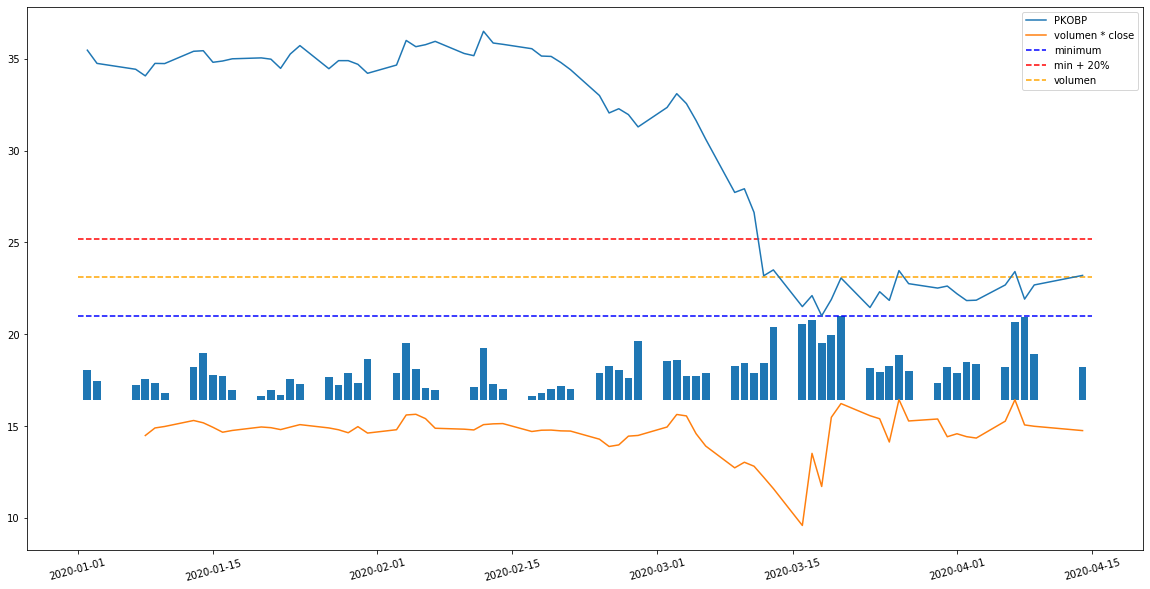

In [175]:
plot_paper(papier,'2020-01-01', str(date.today()))

In [145]:
(current,
data_max_before_crisis,
 data_crises_min,
 data_max_after_drop,
 data_min_after_max,
date_max_after_drop) = prepare_stats_forone(papier, before_crises, big_drop_date)

In [146]:
print(f'Paper: {papier}, currently at {current[0]}, with potential \
{round(data_max_before_crisis*100/current[0]-100, 2)}% to top')
print(f'Max before crisis: {data_max_before_crisis}')
print(f'Crisis bottom: {data_crises_min}')
print(f'Max after crisis drop: {data_max_after_drop}, at {date_max_after_drop[0]}')
print(f'Stats after Max: {data_min_after_max.values}')

Paper: PLAY, currently at 33.8, with potential 12.43% to top
Max before crisis: 38.0
Crisis bottom: 25.94
Max after crisis drop: 33.8, at 2020-04-09 00:00:00
Stats after Max: [33.8]


## Skaner

In [9]:
before_crisis = '2020-02-17'
top_bottom = '2020-03-12'
new_year = '2020-01-01'
last_y_quarter = '2019-10-01'
last_y_mid = '2019-06-03'

df_cols = [
    'ticker', 'current', 'before_crisis', 'last_y_q', 'last_y_mid',
    'crisis_bottom', 'max_after_crisis', 'max_before_crisis'
]

### All papers

In [10]:
skaner_df = pd.DataFrame(columns=df_cols)
for w in tqdm(all_stocks):
    
    df = prepare_data(w)
   
    skaner_df = pd.concat([skaner_df,
                       pd.DataFrame([[
                    df.TICKER[0],
                    df.loc[:,'CLOSE'].tail(1).values[0],
                    df.loc[df.index == before_crisis ,'CLOSE'].max(),
                    df.loc[df.index == last_y_quarter ,'CLOSE'].max(),
                           df.loc[df.index == last_y_mid,'CLOSE'].max(),
                    df.loc[(df.index >= top_bottom) & (df.index <= today),'CLOSE'].min(),
                    df.loc[df.index > top_bottom ,'CLOSE'].max(),
                    df.loc[(df.index >= last_y_quarter) & (df.index <= before_crisis),'CLOSE'].max()
                    
                       ]],
                                    columns=df_cols)], axis = 0)

100%|██████████| 1966/1966 [00:11<00:00, 171.97it/s]


In [11]:
skaner_df.loc[:,'growth_quarter'] = round(skaner_df.loc[:,'before_crisis'] * 100 / skaner_df.loc[:,'last_y_q'] - 100, 2)
skaner_df.loc[:,'growth_mid'] = round(skaner_df.loc[:,'last_y_q'] * 100 / skaner_df.loc[:,'last_y_mid'] - 100, 2)
skaner_df.loc[:,'growth_from_crisis'] = round(skaner_df.loc[:,'max_after_crisis'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_potential'] = round((skaner_df.loc[:,'max_before_crisis'] * 100) / skaner_df.loc[:,'current'] - 100, 2)
skaner_df.loc[:,'drop_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'max_before_crisis'] - 100, 2)

In [12]:
skaner_df_see = skaner_df.loc[
    (skaner_df.growth_quarter > 0) 
        #& (skaner_df.growth_mid > 0) 
        #& (skaner_df.drop_current < 0) 
        & (skaner_df.growth_current > 0)
                              ,:].sort_values('drop_current', ascending=True)

In [13]:
skaner_df_see = skaner_df_see.loc[
    skaner_df_see.ticker.apply(lambda x: 
                               False if ('RCFL' in x) 
                               | ('INTLGLD' in x) 
                               | ('RCFS' in x)
                               | ('INTL' in x)
                               | ('INTS' in x)
                               | ('RCTL' in x)
                               | ('BETA' in x)
                               | ('RCL' in x) else True).values,]

In [14]:
skaner_df_see.shape

(237, 14)

## Monitoring

In [89]:
to_monitor_list = ['ASBIS', 'UNIMOT',
            'CLNPHARMA', 'SUNEX', 
            'ELKOP', 'ABPL', 
            'MLSYSTEM',
            'AMBRA', 'INTERAOLT', 
            'LENA', 'ARCHICOM', 
            'KREC', 'INTERCARS', 'WIRTUALNA',
            'PLAY', 'MOSTALPLC', 'WIELTON']

In [90]:
df_merged = prepare_data(to_monitor_list[0]).loc[:,['CLOSE', 'TICKER', 'VOL']].copy()
df_merged = df_merged.loc[df_merged.index >= '2020-01-01'].copy()
df_merged.loc[:,'CLOSE'] = ((df_merged.loc[:,'CLOSE'] - df_merged.loc[:,'CLOSE'].mean()) 
                            / df_merged.loc[:,'CLOSE'].std())
df_merged.loc[:,'VOL'] = ((df_merged.loc[:,'VOL'] - df_merged.loc[:,'VOL'].mean()) 
                            / df_merged.loc[:,'VOL'].std())

In [91]:
for a in tqdm(to_monitor_list[1:]):

    df = prepare_data(a)
    df = df.loc[df.index >= '2020-01-01', ['CLOSE', 'TICKER', 'VOL']].copy()
    df.loc[:,'CLOSE'] = ((df.loc[:,'CLOSE'] - df.loc[:,'CLOSE'].mean()) 
                                / df.loc[:,'CLOSE'].std())
    df.loc[:,'VOL'] = ((df.loc[:,'VOL'] - df.loc[:,'VOL'].mean()) 
                                / df.loc[:,'VOL'].std())
        
    df_merged = pd.merge(df_merged, df,
                     left_index=True,
                     right_index=True,
                        how = 'outer')

100%|██████████| 16/16 [00:00<00:00, 79.36it/s]


In [92]:
df_stats = pd.DataFrame()

In [93]:
for t in ['CLOSE', 'VOL']:
    df_merged_limited = df_merged.loc[:, [c for c in df_merged.columns if t in c]]
    df_stats.loc[:,f'{t}_sum'] = df_merged_limited.sum(axis = 1)
    df_stats.loc[:,f'{t}_std'] = df_merged_limited.std(axis = 1)
    df_stats.loc[:,f'{t}_mean'] = df_merged_limited.mean(axis = 1)
    df_stats.loc[:,f'{t}_median'] = df_merged_limited.median(axis = 1)
    df_stats.loc[:,f'{t}_q90'] = df_merged_limited.quantile(0.9,axis = 1)
    df_stats.loc[:,f'{t}_q10'] = df_merged_limited.quantile(0.1,axis = 1)

In [94]:
for n in [5, 20]:
    
    df_stats.loc[:,f'CLOSE_mean_rolling{n}'] = df_stats.loc[:,'CLOSE_mean'].rolling(n).mean()
    df_stats.loc[:,f'VOL_mean_rolling{n}'] = df_stats.loc[:,'VOL_mean'].rolling(n).mean()

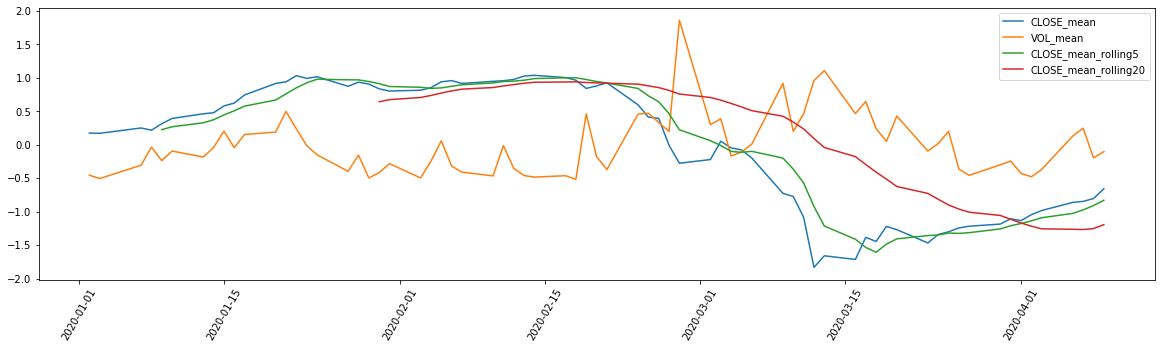

In [95]:
plt.figure(figsize=(20,5))
cols_to_plot = ['CLOSE_mean', 'VOL_mean',
                        'CLOSE_mean_rolling5',
                        'CLOSE_mean_rolling20']
plt.plot(df_stats.loc[:,cols_to_plot])
plt.xticks(rotation=60)
plt.legend(cols_to_plot)

## Model

In [49]:
def transform_one_paper_ch(df):
    
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
        
#     df.loc[:,'chng_OPEN1_CLOSE'] = (df.loc[:,'OPEN'].shift(1) * 100 / df.loc[:,'CLOSE']) - 100
#     df.loc[:,'chng_LOW1_CLOSE'] = (df.loc[:,'LOW'].shift(1) * 100 / df.loc[:,'CLOSE']) - 100
#     df.loc[:,'chng_HIGH1_CLOSE'] = (df.loc[:,'HIGH'].shift(1) * 100 / df.loc[:,'CLOSE']) - 100
        
    df.loc[:,'move_strength_abs'] =  abs(df.loc[:,'chng_CLOSE']) * abs(df.loc[:,'chng_VOL'])
    df.loc[:,'move_strength'] =  (df.loc[:,'chng_CLOSE']) * (df.loc[:,'chng_VOL'])
    
    
### COMPARISON SECTION
#are you on losing strike?
#str strike
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        for i in [5,10,20,30,60]:
            df.loc[:,f'comp{i}d_max' + col] = df.loc[:,col].rolling(i).max()
            df.loc[:,f'comp{i}d_max' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_max' + col]) - 100
            
            df.loc[:,f'comp{i}d_min' + col] = df.loc[:,col].rolling(i).min()
            df.loc[:,f'comp{i}d_min' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_min' + col]) - 100
            
            df.loc[:,f'comp{i}d_mean' + col] = df.loc[:,col].rolling(i).mean()
            df.loc[:,f'comp{i}d_mean' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_mean' + col]) - 100
            
            df.loc[:,f'comp{i}d_std' + col] = df.loc[:,col].rolling(i).std()
            df.loc[:,f'comp{i}d_std' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_std' + col]) - 100
            
    
#     for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
#         cols = [f'comp{i}d_max' + col for i in [5,10,20]]
#         #df.loc[:,'all_higher_f'] = (df[cols] > 0).sum(axis = 1)
#         df.loc[:,'all_higher_cat'] = (df[cols] > 0).astype(str).sum(axis = 1)
        
#         cols = [f'comp{i}d_min' + col for i in [5,10,20]]
#         #df.loc[:,'all_lower_f'] = (df[cols] < 0).sum(axis = 1)
#         df.loc[:,'all_lower_cat'] = (df[cols] < 0).astype(str).sum(axis = 1)
    
            
### FUTURE SECTION ###

#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 0
    
    #df.loc[:, 'fut_OPEN_CLOSE_chng'] = (df.loc[:, 'OPEN'].shift(-1) * 100 / df.loc[:, 'CLOSE']) - 100
    
#     df.loc[:, 'chng_rel_OPEN'] = np.nan
#     df.loc[df.loc[:, 'HIGH'] > df.loc[:, 'OPEN'] * 1.01,'chng_rel_OPEN'] = 1
#     df.loc[df.loc[:, 'HIGH'] <= df.loc[:, 'OPEN'] * 1.01, 'chng_rel_OPEN'] = 0
    
#     df.loc[df.loc[:, 'OPEN'] < df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 1
#     df.loc[df.loc[:, 'OPEN'] >= df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 0


### DIFFS SECTION ###
    df.loc[:,'diff_LOW_HIGH'] = (df.loc[:,'HIGH'] - df.loc[:,'LOW']) / df.loc[:,'HIGH']
    df.loc[:,'diff_OPEN_CLOSE'] = (df.loc[:,'OPEN'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_LOW_CLOSE'] = (df.loc[:,'CLOSE'] - df.loc[:,'LOW']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_HIGH_CLOSE'] = (df.loc[:,'HIGH'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    
    
### HISTORIC SECTION ###

    for a in [c for c in df.columns if ('diff_' in c) | ('chng' in c) | ('chng_' in c)]:
        for i in [1, 2, 3]:
            df.loc[:,f'hist{i}_' + a] = df.loc[:,a].shift(i)

### GET SOME MEANS ###
#Trye min and maxes and some std?
    for b in [c for c in df.columns if (('chng_' in c) 
                                        | ('move_' in c) 
                                        | ('diff_' in c)
                                       | ('same_' in c)) & ('hist' not in c)]:
        for g in [2, 3, 5, 10, 20]:
            df.loc[:,f'roll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
            df.loc[:,f'roll{g}min_' + b] = df.loc[:,b].rolling(g).min()
            df.loc[:,f'roll{g}max_' + b] = df.loc[:,b].rolling(g).max()
            df.loc[:,f'roll{g}std_' + b] = df.loc[:,b].rolling(g).std()


### SUBTARGET ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'subtarget'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'subtarget'] = 0
            
### TARGET SECTION ###
#pick one the of the available sections

## HIGHER HIGH ###
#     df.loc[df.loc[:, 'HIGH'].shift(-1) > df.loc[:, 'HIGH'],'target'] = 1
#     df.loc[df.loc[:, 'HIGH'].shift(-1) <= df.loc[:, 'HIGH'],'target'] = 0

### LOWER LOW ###
#     df.loc[df.loc[:, 'LOW'].shift(-1) < df.loc[:, 'LOW'],'target'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(-1) >= df.loc[:, 'LOW'],'target'] = 0
    
### HIGHER OPENING ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'target'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'target'] = 0
    
# ### HIGHER CLOSING THAN OPENING ###
#     df.loc[df.loc[:, 'CLOSE'].shift(-1) > df.loc[:, 'OPEN'].shift(-1),'target'] = 1
#     df.loc[df.loc[:, 'CLOSE'].shift(-1) <= df.loc[:, 'OPEN'].shift(-1),'target'] = 0

### OPENING NOT FAR FROM LOW ###
    df.loc[df.loc[:, 'OPEN'].shift(-1)*0.995 > df.loc[:, 'LOW'].shift(-1),'target'] = 0
    df.loc[df.loc[:, 'OPEN'].shift(-1)*0.995 <= df.loc[:, 'LOW'].shift(-1),'target'] = 1
    
    return df

def transform_one_index(df):
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
    return df

In [ ]:
df_merged = pd.DataFrame()

for p in tqdm(list(skaner_df_see.ticker.values) + watch):
    
    df = prepare_data(p)
        
    df = transform_one_paper_ch(df) 
    df = df.dropna()
    
    df_merged = pd.concat([df_merged, df])
    del df

 69%|██████▉   | 181/262 [04:54<03:30,  2.60s/it]

In [ ]:
df_indexes_merged = pd.DataFrame()

for p in tqdm(all_indekses):
    
    df = prepare_index(p)
        
    df = transform_one_index(df) 
    #df = df.dropna()
    
    df_indexes_merged = pd.concat([df_indexes_merged, df])
    del df

In [ ]:
df_indexes_merged = df_indexes_merged.pivot_table(index='DTYYYYMMDD', columns='TICKER', values='chng_CLOSE')
df_indexes_merged = df_indexes_merged.agg(['mean', 'max', 'min', 'std'], axis = 1)
df_indexes_merged = df_indexes_merged.add_prefix('foreign_stocks_')

df_merged = df_merged.merge(df_indexes_merged, left_index=True, right_index=True, how = 'left')

In [ ]:
train_cols = [c for c in df_merged.columns if ('chng' in c) | ('move' in c) 
              | ('comp' in c) | ('fut' in c) | ('diff' in c) | ('same' in c) | ('hist' in c)]

train_cols = train_cols + list(df_indexes_merged.columns)

#train_cols = ['all_lower_cat', 'all_higher_cat'] + train_cols

In [ ]:
#train_cols = train_cols_limited

df = df_merged.copy()

In [ ]:
cut_date = '2020-03-01'
train_data = df.loc[df.index < cut_date,train_cols]
eval_data = df.loc[df.index >= cut_date,train_cols]
train_labels = df.loc[df.index < cut_date,'target'].values
eval_labels = df.loc[df.index >= cut_date,'target'].values

In [22]:
def get_model():
    # Initialize CatBoostClassifier
    model = CatBoostClassifier(iterations=10000,
                           learning_rate=0.05,
                           depth=3,
                          thread_count=4,
                          eval_metric='AUC',
                          task_type='GPU')
    return model


# kf = KFold(n_splits=4)
# kf.get_n_splits(train_data)


# results = pd.DataFrame()
# models = []

# for train_index, test_index in kf.split(train_data):
#     X_train, X_test = train_data.iloc[train_index, :], train_data.iloc[
#         test_index, :]
#     y_train, y_test = train_labels[train_index], train_labels[test_index]

#     model = get_model()

#     model.fit(train_data,
#               train_labels,
#               #cat_features=[0, 1],
#               eval_set=[(train_data, train_labels),
#                         (eval_data[:-1], eval_labels[:-1])],
#               early_stopping_rounds=100,
#               use_best_model=True)

#     model.predict_proba(X_test)

#     one_fold_results = pd.concat(
#         [pd.Series(model.predict_proba(X_test)[:, 1]),
#          pd.Series(y_test)],
#         axis=1)
    
#     results = pd.concat([results, one_fold_results])
    
#     models.append(model)

In [23]:
model = get_model()

In [24]:
model.fit(train_data, train_labels, #cat_features=[0, 1],
          eval_set=[(eval_data[:-1], eval_labels[:-1])],
         early_stopping_rounds=100, use_best_model=True)

0:	learn: 0.6793571	test: 0.6777381	best: 0.6777381 (0)	total: 29.4ms	remaining: 4m 53s
1:	learn: 0.6806160	test: 0.6783025	best: 0.6783025 (1)	total: 47ms	remaining: 3m 55s
2:	learn: 0.6831408	test: 0.6787456	best: 0.6787456 (2)	total: 64.8ms	remaining: 3m 36s
3:	learn: 0.6903576	test: 0.6767954	best: 0.6787456 (2)	total: 82.4ms	remaining: 3m 26s
4:	learn: 0.6955062	test: 0.6794374	best: 0.6794374 (4)	total: 99.6ms	remaining: 3m 19s
5:	learn: 0.6969388	test: 0.6800580	best: 0.6800580 (5)	total: 118ms	remaining: 3m 15s
6:	learn: 0.6994518	test: 0.6804763	best: 0.6804763 (6)	total: 135ms	remaining: 3m 13s
7:	learn: 0.7003597	test: 0.6807201	best: 0.6807201 (7)	total: 152ms	remaining: 3m 10s
8:	learn: 0.7009202	test: 0.6808968	best: 0.6808968 (8)	total: 169ms	remaining: 3m 7s
9:	learn: 0.7017397	test: 0.6813452	best: 0.6813452 (9)	total: 187ms	remaining: 3m 6s
10:	learn: 0.7032136	test: 0.6821440	best: 0.6821440 (10)	total: 205ms	remaining: 3m 6s
11:	learn: 0.7046263	test: 0.6819978	best

95:	learn: 0.7316886	test: 0.6991037	best: 0.6991037 (95)	total: 1.48s	remaining: 2m 32s
96:	learn: 0.7317957	test: 0.6991774	best: 0.6991774 (96)	total: 1.49s	remaining: 2m 32s
97:	learn: 0.7318740	test: 0.6992408	best: 0.6992408 (97)	total: 1.51s	remaining: 2m 32s
98:	learn: 0.7319825	test: 0.6992598	best: 0.6992598 (98)	total: 1.52s	remaining: 2m 32s
99:	learn: 0.7320893	test: 0.6991906	best: 0.6992598 (98)	total: 1.54s	remaining: 2m 32s
100:	learn: 0.7322009	test: 0.6993136	best: 0.6993136 (100)	total: 1.55s	remaining: 2m 32s
101:	learn: 0.7322918	test: 0.6990257	best: 0.6993136 (100)	total: 1.56s	remaining: 2m 31s
102:	learn: 0.7323997	test: 0.6991561	best: 0.6993136 (100)	total: 1.58s	remaining: 2m 31s
103:	learn: 0.7324586	test: 0.6992460	best: 0.6993136 (100)	total: 1.59s	remaining: 2m 31s
104:	learn: 0.7325551	test: 0.6991946	best: 0.6993136 (100)	total: 1.61s	remaining: 2m 31s
105:	learn: 0.7326865	test: 0.6991635	best: 0.6993136 (100)	total: 1.62s	remaining: 2m 31s
106:	lear

198:	learn: 0.7382815	test: 0.7024630	best: 0.7025402 (194)	total: 2.94s	remaining: 2m 24s
199:	learn: 0.7383362	test: 0.7024567	best: 0.7025402 (194)	total: 2.96s	remaining: 2m 24s
200:	learn: 0.7383870	test: 0.7025033	best: 0.7025402 (194)	total: 2.97s	remaining: 2m 24s
201:	learn: 0.7384052	test: 0.7025369	best: 0.7025402 (194)	total: 2.98s	remaining: 2m 24s
202:	learn: 0.7384431	test: 0.7025273	best: 0.7025402 (194)	total: 3s	remaining: 2m 24s
203:	learn: 0.7384812	test: 0.7025267	best: 0.7025402 (194)	total: 3.01s	remaining: 2m 24s
204:	learn: 0.7385117	test: 0.7026200	best: 0.7026200 (204)	total: 3.03s	remaining: 2m 24s
205:	learn: 0.7385482	test: 0.7026967	best: 0.7026967 (205)	total: 3.04s	remaining: 2m 24s
206:	learn: 0.7385849	test: 0.7026132	best: 0.7026967 (205)	total: 3.06s	remaining: 2m 24s
207:	learn: 0.7386333	test: 0.7026348	best: 0.7026967 (205)	total: 3.07s	remaining: 2m 24s
208:	learn: 0.7386594	test: 0.7026325	best: 0.7026967 (205)	total: 3.08s	remaining: 2m 24s
20

299:	learn: 0.7415434	test: 0.7047023	best: 0.7048052 (292)	total: 4.39s	remaining: 2m 21s
300:	learn: 0.7415720	test: 0.7051032	best: 0.7051032 (300)	total: 4.41s	remaining: 2m 21s
301:	learn: 0.7416061	test: 0.7051588	best: 0.7051588 (301)	total: 4.42s	remaining: 2m 22s
302:	learn: 0.7416294	test: 0.7052723	best: 0.7052723 (302)	total: 4.44s	remaining: 2m 22s
303:	learn: 0.7416728	test: 0.7052931	best: 0.7052931 (303)	total: 4.45s	remaining: 2m 22s
304:	learn: 0.7416933	test: 0.7052426	best: 0.7052931 (303)	total: 4.47s	remaining: 2m 21s
305:	learn: 0.7417166	test: 0.7052854	best: 0.7052931 (303)	total: 4.48s	remaining: 2m 21s
306:	learn: 0.7417270	test: 0.7052956	best: 0.7052956 (306)	total: 4.5s	remaining: 2m 21s
307:	learn: 0.7417462	test: 0.7053277	best: 0.7053277 (307)	total: 4.51s	remaining: 2m 21s
308:	learn: 0.7417629	test: 0.7053556	best: 0.7053556 (308)	total: 4.52s	remaining: 2m 21s
309:	learn: 0.7417855	test: 0.7057185	best: 0.7057185 (309)	total: 4.54s	remaining: 2m 21s


399:	learn: 0.7435369	test: 0.7069942	best: 0.7070545 (397)	total: 5.83s	remaining: 2m 20s
400:	learn: 0.7435508	test: 0.7070048	best: 0.7070545 (397)	total: 5.85s	remaining: 2m 20s
401:	learn: 0.7435626	test: 0.7070214	best: 0.7070545 (397)	total: 5.86s	remaining: 2m 20s
402:	learn: 0.7435746	test: 0.7070389	best: 0.7070545 (397)	total: 5.88s	remaining: 2m 20s
403:	learn: 0.7435889	test: 0.7070099	best: 0.7070545 (397)	total: 5.89s	remaining: 2m 19s
404:	learn: 0.7436054	test: 0.7070685	best: 0.7070685 (404)	total: 5.91s	remaining: 2m 19s
405:	learn: 0.7436171	test: 0.7070860	best: 0.7070860 (405)	total: 5.92s	remaining: 2m 19s
406:	learn: 0.7436399	test: 0.7070795	best: 0.7070860 (405)	total: 5.94s	remaining: 2m 19s
407:	learn: 0.7436595	test: 0.7070886	best: 0.7070886 (407)	total: 5.95s	remaining: 2m 19s
408:	learn: 0.7436757	test: 0.7072276	best: 0.7072276 (408)	total: 5.97s	remaining: 2m 19s
409:	learn: 0.7436863	test: 0.7071587	best: 0.7072276 (408)	total: 5.98s	remaining: 2m 19s

499:	learn: 0.7449699	test: 0.7053465	best: 0.7072276 (408)	total: 7.26s	remaining: 2m 18s
500:	learn: 0.7449953	test: 0.7053536	best: 0.7072276 (408)	total: 7.28s	remaining: 2m 18s
501:	learn: 0.7450106	test: 0.7053504	best: 0.7072276 (408)	total: 7.29s	remaining: 2m 18s
502:	learn: 0.7450278	test: 0.7053839	best: 0.7072276 (408)	total: 7.31s	remaining: 2m 18s
503:	learn: 0.7450420	test: 0.7054256	best: 0.7072276 (408)	total: 7.32s	remaining: 2m 17s
504:	learn: 0.7450648	test: 0.7054492	best: 0.7072276 (408)	total: 7.34s	remaining: 2m 17s
505:	learn: 0.7450745	test: 0.7054654	best: 0.7072276 (408)	total: 7.35s	remaining: 2m 17s
506:	learn: 0.7450842	test: 0.7054649	best: 0.7072276 (408)	total: 7.37s	remaining: 2m 17s
507:	learn: 0.7450923	test: 0.7054636	best: 0.7072276 (408)	total: 7.38s	remaining: 2m 17s
508:	learn: 0.7451000	test: 0.7054732	best: 0.7072276 (408)	total: 7.4s	remaining: 2m 17s
bestTest = 0.7072276473
bestIteration = 408
Shrink model to first 409 iterations.


In [25]:
model.get_feature_importance(prettified=True).head(100)

,Feature Id,Importances
0,diff_LOW_CLOSE,45.229852
1,diff_OPEN_CLOSE,9.908394
2,foreign_stocks_mean,6.132900
3,roll20m_diff_LOW_CLOSE,4.534967
4,chng_CLOSE,4.062414
5,roll20min_diff_LOW_HIGH,2.261481
6,comp5d_meanLOW,2.238979
7,chng_LOW,2.182225
8,roll20m_diff_LOW_HIGH,2.155893
9,comp60d_meanVOL,1.525750


In [26]:
working_feats_785_on_high = ['diff_HIGH_CLOSE', 'diff_OPEN_CLOSE','roll20min_diff_LOW_HIGH',
                     'chng_HIGH','roll2std_chng_HIGH',
                     'comp5d_stdHIGH','roll20min_chng_VOL','comp5d_meanOPEN','move_strength_abs',
                     'roll2min_chng_HIGH','roll3min_move_strength_abs']

imp = model.get_feature_importance(prettified=True)
train_cols_limited  = [c for c in train_cols if c in imp.loc[imp.Importances >= 0.01, 'Feature Id'].values]
#train_cols_limited = working_feats_785_on_high
len(train_cols) - len(train_cols_limited)

218

#### Analysis categorical

In [27]:
preds_class = model.predict(eval_data)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_data)
# Get predicted RawFormulaVal
preds_raw = model.predict(eval_data, prediction_type='RawFormulaVal')

# pred_class = pd.Series()

# for m in models:
#     if not pred_class.shape[0]:
#         pred_class = m.predict(eval_data)
#     else:
#         pred_class = pred_class + m.predict(eval_data)

# pred_class = pred_class / 4

preds = preds_class[:-1].astype(int)

In [110]:
# preds_proba = pd.Series()

# for m in models:
#     if not pred_class.shape[0]:
#         preds_proba = m.predict_proba(eval_data)[:,1]
#     else:
#         preds_proba = pred_class + m.predict_proba(eval_data)[:,1]

# preds_proba = preds_proba / 4

# preds_proba = preds_proba[:,1]

preds = preds_proba

preds[preds > 0.51] = 1
preds[preds < 1] = 0
preds = preds[:-1].astype(int)

In [28]:
confusion_matrix(eval_labels[:-1].astype(int), preds)

array([[3118, 1411],
       [1267, 2102]])

In [29]:
tn, fp, fn, tp = confusion_matrix(eval_labels[:-1].astype(int), preds).ravel()
(tn, fp, fn, tp)

(3118, 1411, 1267, 2102)

In [30]:
(tn + tp) / (tn + tp + fp + fn)

0.6609268169156749

In [31]:
tp / (tp + fp)

0.5983489894676914

In [32]:
df_res = pd.concat([pd.DataFrame(preds_proba), pd.Series(eval_labels)], axis=1)
df_res.columns = ['zero', 'one', 'true']
df_res.groupby('true').mean()

,zero,one
true,,
0.0,0.627963,0.372037
1.0,0.451352,0.548648


In [33]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(1)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(1)
df_res_grouped = df_res.drop('zero', axis = 1)

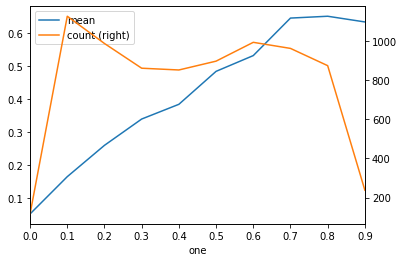

In [34]:
# df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3
# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.55
df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])
df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)
df_res_grouped = df_res_grouped.reset_index().set_index('one')

df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

In [35]:
df_res_grouped

,mean,count
one,,
0.0,0.051282,117
0.1,0.164444,1125
0.2,0.259635,986
0.3,0.339535,860
0.4,0.384254,851
0.5,0.484375,896
0.6,0.532258,992
0.7,0.646202,961
0.8,0.651775,873


### Prediction

#### Categorical

In [36]:
eval_data.loc[:,'target'] = eval_labels
eval_data.loc[:,'target'] = eval_data.loc[:,'target']
eval_data.loc[:,'pred_class'] = model.predict(eval_data[train_cols])

eval_data.loc[:,'pred_proba'] = model.predict_proba(eval_data[train_cols])[:,1]
eval_data.loc[:,'pred_proba'] = eval_data.loc[:,'pred_proba'].round(1)

#### Prediction for couple of papers

In [37]:
res = pd.DataFrame()

In [38]:
for p in tqdm(list(skaner_df_see.ticker.values) + watch):

    df = prepare_data(p)
    df = transform_one_paper_ch(df)

    df = df.merge(df_indexes_merged,
                  left_index=True,
                  right_index=True,
                  how='left')

    df.loc[:, 'pred_class'] = model.predict(df[train_cols])
    df.loc[:, 'pred_prob'] = model.predict_proba(df[train_cols])[:, 1]

    df.loc[:, 'fut_OPEN'] = df.loc[:, 'OPEN'].shift(-1)
    df.loc[:, 'fut_CLOSE'] = df.loc[:, 'CLOSE'].shift(-1)
    df.loc[:, 'target_gains'] = (df.loc[:, 'fut_CLOSE'] * 100 /
                                 df.loc[:, 'fut_OPEN']) - 100
    df.loc[:, 'target_OPEN_chng'] = (df.loc[:, 'fut_OPEN'] * 100 /
                                     df.loc[:, 'CLOSE']) - 100
    df.loc[:, 'target_HIGH_chng'] = df.loc[:, 'chng_HIGH'].shift(-1).copy()
    df.loc[:, 'target_CLOSE_chng'] = df.loc[:, 'chng_CLOSE'].shift(-1).copy()

    one_res = df.reset_index().loc[:, [
        'DTYYYYMMDD', 'TICKER', 'OPEN', 'LOW', 'HIGH', 'CLOSE', 'target',
        'pred_class', 'target_OPEN_chng', 'target_HIGH_chng',
        'target_CLOSE_chng', 'target_gains', 'pred_prob'
    ]].tail(15)
    res = pd.concat([res, one_res])

100%|██████████| 262/262 [03:43<00:00,  1.17it/s]


In [39]:
res_see = res.sort_values('pred_prob', ascending=False).copy()
res_see = res_see.drop_duplicates()
res_see.loc[res_see.pred_prob > 0.5].groupby('DTYYYYMMDD').mean().mean()

OPEN                 649.170584
LOW                  642.203946
HIGH                 652.231254
CLOSE                644.142754
target                 0.608995
pred_class             1.000000
target_OPEN_chng      -0.412887
target_HIGH_chng      -0.363944
target_CLOSE_chng     -0.169023
target_gains           0.257719
pred_prob              0.658128
dtype: float64

In [42]:
res_see.loc[:,'pred_prob_rounded'] = res_see.pred_prob.round(1)

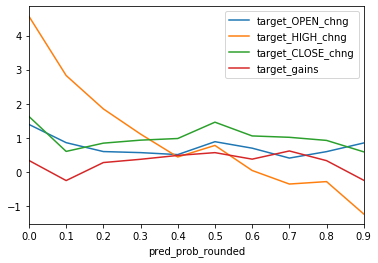

In [46]:
res_see.groupby('pred_prob_rounded').mean()[['target_OPEN_chng', 'target_HIGH_chng', 'target_CLOSE_chng', 'target_gains']].plot()

In [40]:
res_see.loc[(res_see.pred_prob < 0.5) & (res_see.loc[:,'DTYYYYMMDD'] == '2020-04-15')].sort_values('pred_prob', ascending=False).head(100)

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,target,pred_class,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng,target_gains,pred_prob
1777,2020-04-15,IZOBLOK,24.800,24.800,26.10,26.10,1.0,0.0,1.915709,1.915709,-6.130268,-7.894737,0.489380
3200,2020-04-15,ERBUD,15.950,15.800,17.50,16.30,0.0,0.0,7.055215,-0.285714,3.680982,-3.151862,0.484219
1798,2020-04-15,IMS,2.760,2.500,2.76,2.70,0.0,0.0,-0.370370,-2.173913,0.000000,0.371747,0.481859
3196,2020-04-15,JWCONSTR,3.010,2.870,3.01,3.00,0.0,0.0,-1.666667,-0.664452,-0.333333,1.355932,0.473362
2324,2020-04-15,ASSECOSEE,29.800,28.500,29.80,29.80,0.0,0.0,0.000000,0.000000,-3.020134,-3.020134,0.471813
2875,2020-04-15,CORMAY,1.150,1.095,1.21,1.15,0.0,0.0,3.478261,-0.413223,0.434783,-2.941176,0.468954
3254,2020-04-15,MIRACULUM,1.250,1.250,1.34,1.30,0.0,0.0,2.692308,0.000000,0.000000,-2.621723,0.459856
3736,2020-04-15,AMREST,30.000,26.100,31.25,28.70,0.0,0.0,-0.348432,-7.360000,-8.536585,-8.216783,0.440674
1944,2020-04-15,ACAUTOGAZ,37.800,36.000,38.20,37.60,0.0,0.0,-2.659574,-1.308901,0.265957,3.005464,0.420304
1918,2020-04-15,ATENDE,2.600,2.520,2.68,2.64,0.0,0.0,0.757576,0.000000,-1.515152,-2.255639,0.418152


In [47]:
res_see.loc[(res_see.TICKER.apply(lambda x: True if x in watch else False) & (res_see.loc[:,'DTYYYYMMDD'] == '2020-04-15')),:]

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,target,pred_class,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng,target_gains,pred_prob,pred_prob_rounded
2444,2020-04-15,TAURONPE,1.18,1.139,1.188,1.139,0.0,1.0,0.965759,0.505051,4.302019,3.304348,0.867501,0.9
2187,2020-04-15,JSW,15.00,13.610,15.185,13.810,1.0,1.0,0.289645,-8.495226,-1.375815,-1.660650,0.858721,0.9
3068,2020-04-15,WIELTON,4.00,3.800,4.090,3.875,0.0,1.0,-1.032258,-2.444988,0.129032,1.173403,0.853305,0.9
3858,2020-04-15,PKOBP,23.31,22.100,23.360,22.140,1.0,1.0,2.077687,-2.868151,-0.451671,-2.477876,0.847926,0.8
5756,2020-04-15,KRUSZWICA,56.40,55.000,57.000,55.200,0.0,1.0,0.724638,-1.754386,-0.362319,-1.079137,0.843135,0.8
3935,2020-04-15,INTERCARS,194.00,178.500,194.000,182.500,0.0,1.0,0.273973,-3.092784,3.013699,2.732240,0.841428,0.8
674,2020-04-15,PLAY,33.60,31.700,33.680,31.960,1.0,1.0,1.063830,-4.097387,-1.063830,-2.105263,0.833514,0.8
6375,2020-04-15,CDPROJEKT,343.70,338.300,344.900,342.200,1.0,1.0,0.175336,-0.086982,-2.337814,-2.508751,0.830268,0.8
2294,2020-04-15,VOTUM,11.10,10.450,11.100,10.500,1.0,1.0,-0.952381,-5.405405,-2.857143,-1.923077,0.829716,0.8
5455,2020-04-15,PEKAO,57.50,54.020,57.580,54.300,1.0,1.0,1.289134,-4.376520,-0.957643,-2.218182,0.825244,0.8


In [408]:
res_see.loc[res_see.DTYYYYMMDD == '2020-04-08']\
.drop_duplicates().head(100).to_excel('gpw_predictions_20200402.xls')

In [261]:
res_std = res_see.groupby('DTYYYYMMDD')\
.mean()[['target_OPEN_chng', 'target_HIGH_chng', 'target_CLOSE_chng', 'pred_prob']]

In [262]:
res_std = (res_std - res_std.mean()) / res_std.std()

In [265]:
res_std.corr()

,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng,pred_prob
target_OPEN_chng,1.000000,0.747667,0.798805,0.259180
target_HIGH_chng,0.747667,1.000000,0.614235,0.644721
target_CLOSE_chng,0.798805,0.614235,1.000000,0.116755
pred_prob,0.259180,0.644721,0.116755,1.000000


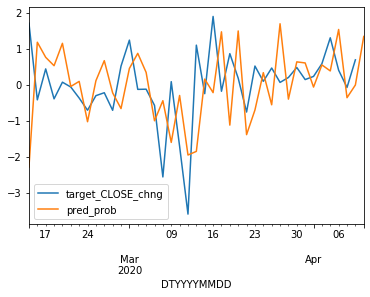

In [264]:
res_std[['target_CLOSE_chng', 'pred_prob']].plot()

In [335]:
df = df_merged.copy()

In [336]:
df.loc[:,'pred_class'] = model.predict(df[train_cols])
df.loc[:,'pred_prob'] = model.predict_proba(df[train_cols])[:,1]

df.loc[:,'fut_OPEN'] = df.loc[:,'OPEN'].shift(-1)
df.loc[:,'target_OPEN_chng'] = (df.loc[:,'fut_OPEN'] * 100 / df.loc[:,'CLOSE']) - 100
df.loc[:,'target_HIGH_chng'] = df.loc[:,'chng_HIGH'].shift(-1).copy()
df.loc[:,'target_CLOSE_chng'] = df.loc[:,'chng_CLOSE'].shift(-1).copy()

In [340]:
res = df.reset_index()

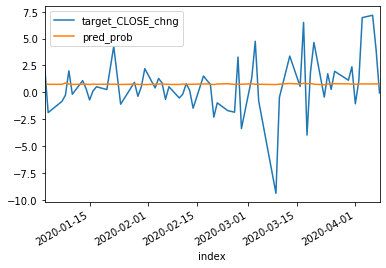

In [354]:
res.loc[(res.loc[:,'index'] > '2020-01-01')
        & (res.pred_prob > 0.7), :].groupby(['index']).mean()[['target_CLOSE_chng', 'pred_prob']].plot()

In [360]:
res.loc[(res.loc[:,'index'] > '2020-01-01')
        & (res.pred_prob > 0.8), :].groupby(['index']).mean()[
    ['target_HIGH_chng','target_CLOSE_chng', 'pred_prob']].median()

target_HIGH_chng     0.202429
target_CLOSE_chng    0.887612
pred_prob            0.833990
dtype: float64

In [355]:
res.sort_values('pred_prob', ascending=False).head(100)

,index,TICKER,OPEN,HIGH,LOW,CLOSE,VOL,OPEN_shifted,chng_OPEN,LOW_shifted,...,target,foreign_stocks_mean,foreign_stocks_max,foreign_stocks_min,pred_class,pred_prob,fut_OPEN,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng
199145,2011-08-11,PGE,17.85,19.250,17.6500,19.250,6.587300e+06,19.150,-6.788512,17.2400,...,1.0,2.857047,5.404341,-0.952958,1.0,0.967548,949.240,4831.116883,-6.512986,9.040890
541326,2020-03-19,WIG20LEV,228.15,248.410,221.7200,248.410,9.736780e+05,234.310,-2.628996,218.3100,...,1.0,1.330692,7.141789,-5.605968,1.0,0.960654,16.400,-93.398011,-4.576659,1.863354
541325,2020-03-19,PGE,3.65,4.036,3.6200,4.036,7.531181e+06,3.520,3.693182,3.3500,...,1.0,1.330692,7.141789,-5.605968,1.0,0.957879,228.150,5552.874133,0.327141,9.721731
199146,2011-08-11,WIG20LEV,949.24,1014.680,863.6800,1014.680,1.683095e+06,1071.960,-11.448188,878.6300,...,1.0,2.857047,5.404341,-0.952958,1.0,0.955207,84.500,-91.672251,-2.526316,4.360465
541313,2020-03-19,CCC,26.00,29.780,25.4000,29.600,2.128518e+06,26.840,-3.129657,24.3000,...,1.0,1.330692,7.141789,-5.605968,1.0,0.954583,3.000,-89.864865,-3.225806,-3.333333
540604,2020-03-13,LOTOS,42.04,45.900,39.8200,44.990,8.754780e+05,40.500,3.802469,39.0000,...,0.0,3.955261,13.908829,-6.080832,1.0,0.954446,1.870,-95.843521,-2.777778,-2.551020
202290,2011-09-15,CDPROJEKT,3.72,3.950,3.7200,3.950,8.404720e+05,3.650,1.917808,3.6200,...,1.0,1.349585,3.271462,-0.332003,1.0,0.952014,2.520,-36.202532,2.325581,4.761905
540955,2020-03-17,CIGAMES,0.41,0.436,0.4000,0.436,2.820567e+06,0.374,9.625668,0.3370,...,1.0,3.179108,13.518576,-3.209159,1.0,0.950566,10.000,2193.577982,-11.297071,0.200401
541403,2020-03-19,WIG30,1631.13,1712.070,1617.3100,1712.070,1.033160e+06,1635.080,-0.241578,1598.5800,...,1.0,1.330692,7.141789,-5.605968,1.0,0.949328,2977.070,73.887166,3.295832,5.038784
540924,2020-03-17,MABION,25.00,31.000,25.0000,31.000,9.760700e+04,20.000,25.000000,18.5000,...,1.0,3.179108,13.518576,-3.209159,1.0,0.947911,4.960,-84.000000,3.488372,6.024096


In [363]:
res.loc[res.pred_prob > 0.7].mean()

OPEN                    694.408521
HIGH                    706.094534
LOW                     691.763361
CLOSE                   705.061505
VOL                  479465.474154
                         ...      
pred_prob                 0.756463
fut_OPEN                361.378365
target_OPEN_chng       3284.682078
target_HIGH_chng          0.329685
target_CLOSE_chng         0.637524
Length: 276, dtype: float64

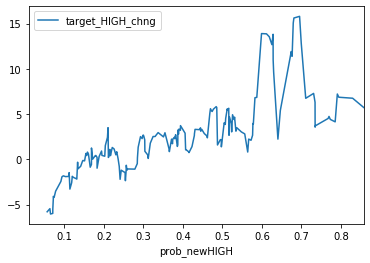

In [162]:
res.loc[:,['target_HIGH_chng', 'prob_newHIGH']]\
.sort_values('prob_newHIGH').set_index('prob_newHIGH').rolling(7).mean().plot()

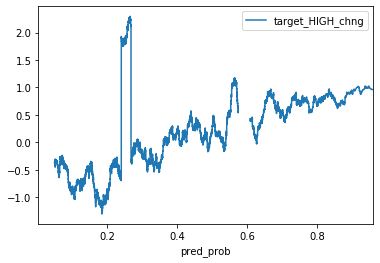

In [375]:
res.loc[res.loc[:,'index'] > '2020-01-01',['target_HIGH_chng', 'pred_prob']]\
.sort_values('pred_prob').set_index('pred_prob').rolling(500).mean().plot()

In [378]:
res.loc[res.loc[:,'index'] > '2020-04-07',:]

,index,TICKER,OPEN,HIGH,LOW,CLOSE,VOL,OPEN_shifted,chng_OPEN,LOW_shifted,...,target,foreign_stocks_mean,foreign_stocks_max,foreign_stocks_min,pred_class,pred_prob,fut_OPEN,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng
543985,2020-04-08,EFEKT,3.16,3.38,2.86,3.24,21180.0,2.58,22.480620,2.54,...,0.0,1.66631,5.106485,-1.166522,0.0,0.403466,25.70,693.209877,-9.507042,-7.692308
543986,2020-04-08,MABION,25.70,25.70,23.40,24.00,75002.0,28.40,-9.507042,25.65,...,0.0,1.66631,5.106485,-1.166522,0.0,0.242316,2.35,-90.208333,-1.673640,-10.638298
543987,2020-04-08,ELBUDOWA,2.35,2.35,1.91,2.10,129473.0,2.35,0.000000,2.18,...,0.0,1.66631,5.106485,-1.166522,0.0,0.113428,33.50,1495.238095,-10.053476,0.240964
543988,2020-04-08,CCC,33.50,33.64,31.50,33.28,521253.0,35.40,-5.367232,33.20,...,1.0,1.66631,5.106485,-1.166522,1.0,0.599440,2.94,-91.165865,-2.000000,-5.172414
543989,2020-04-08,SOLAR,2.94,2.94,2.65,2.75,10255.0,2.59,13.513514,2.48,...,0.0,1.66631,5.106485,-1.166522,0.0,0.181260,10.20,270.909091,-7.488987,-3.921569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544174,2020-04-08,EVEREST,7.20,7.20,7.00,7.20,1030.0,7.50,-4.000000,7.00,...,0.0,1.66631,5.106485,-1.166522,0.0,0.498369,8.00,11.111111,-0.934579,22.401848
544175,2020-04-08,PHARMENA,8.00,10.60,7.28,10.60,20106.0,10.50,-23.809524,8.52,...,1.0,1.66631,5.106485,-1.166522,1.0,0.701910,3.13,-70.471698,-24.074074,0.000000
544176,2020-04-08,BIOMEDLUB,3.13,4.10,2.64,3.40,9752784.0,5.10,-38.627451,3.33,...,1.0,1.66631,5.106485,-1.166522,1.0,0.529845,3.30,-2.941176,-13.157895,-5.120482
544177,2020-04-08,HARPER,3.30,3.30,2.97,3.15,164611.0,3.70,-10.810811,3.21,...,0.0,1.66631,5.106485,-1.166522,0.0,0.337076,0.27,-91.428571,-3.571429,-3.571429


#### Regression

In [103]:
df.loc[:, 'preds'] = model.predict(df[train_cols])

In [104]:
df.loc[:,['target', 'preds', 'OPEN', 'CLOSE']]

,target,preds,OPEN,CLOSE
DTYYYYMMDD,,,,
2017-07-27,0.027887,0.405700,36.00,35.50
2017-07-28,0.016772,0.115789,35.50,36.25
2017-07-31,0.012212,0.110641,36.37,36.80
2017-08-01,0.024067,0.119130,36.85,36.89
2017-08-02,0.013740,0.046849,36.98,36.50
...,...,...,...,...
2020-04-02,0.049110,0.034687,28.40,28.56
2020-04-03,0.036328,0.037045,28.10,29.48
2020-04-06,0.033443,0.032499,30.28,29.86


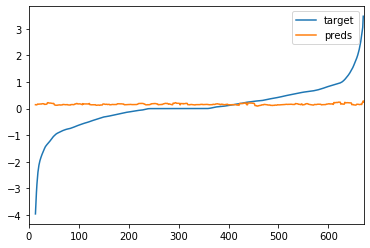

In [220]:
df.sort_values('target').reset_index()[['target', 'preds']].rolling(14).mean().plot()

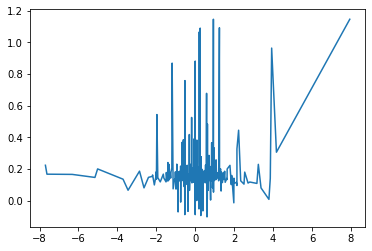

In [210]:
plt.plot(df.sort_values('target').target, df.sort_values('target').preds)

In [191]:
for c in ['preds', 'target']:
    df.loc[df.loc[:, c] > 0, c] = 1
    df.loc[df.loc[:, c] < 1, c] = 0

In [195]:
confusion_matrix(df.target[:-1].astype(int), df.preds[:-1].astype(int))

array([[  6, 351],
       [  6, 308]])

In [196]:
tn, fp, fn, tp = confusion_matrix(df.target[:-1].astype(int), df.preds[:-1].astype(int)).ravel()
(tn, fp, fn, tp)

(6, 351, 6, 308)

In [198]:
df.preds

DTYYYYMMDD
2017-07-27    1.0
2017-07-28    1.0
2017-07-31    1.0
2017-08-01    1.0
2017-08-02    1.0
             ... 
2020-04-02    1.0
2020-04-03    1.0
2020-04-06    1.0
2020-04-07    1.0
2020-04-08    0.0
Name: preds, Length: 672, dtype: float64

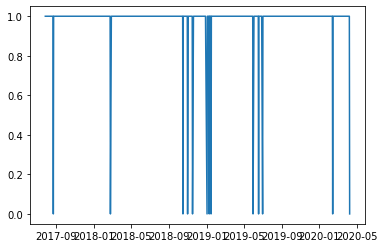

In [197]:
plt.plot(df.preds)

In [ ]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(2)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(2)

df_res_grouped = df_res.drop('zero', axis = 1)

df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3

# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.54

df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])

df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)

df_res_grouped = df_res_grouped.reset_index().set_index('one')

df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

df_res_grouped

## Foreign indexes

## Other

### Reports

In [42]:
all_reports = pd.read_csv('../bizcrap/fundamental_reports.csv')

In [61]:
cols_to_change = list(all_reports.columns)
cols_to_change[0] = 'Data'
all_reports.columns = cols_to_change

In [45]:
[a for a in all_reports.name.unique() if 'ORLEN' in a]

['raporty-PKN-ORLEN,Q.html']

In [55]:
cols_zysk = [c for c in all_reports.columns if 'zysk' in c]

In [53]:
for c in all_reports.columns:
    all_reports.loc[all_reports.loc[:,c]==-1,c] = np.nan

In [62]:
all_reports.head()

,Data,name,przychody_ze_sprzedaży_main,przychody_ze_sprzedaży_kk,przychody_ze_sprzedaży_sector,techniczny_koszt_wytworzenia_produkcji_sprzedanej_main,techniczny_koszt_wytworzenia_produkcji_sprzedanej_kk,techniczny_koszt_wytworzenia_produkcji_sprzedanej_sector,koszty_sprzedaży_main,koszty_sprzedaży_kk,...,odpisy_netto_z_tytułu_utraty_wartości_kredytów_sector,ogólne_koszty_administracyjne_main,ogólne_koszty_administracyjne_kk,ogólne_koszty_administracyjne_sector,wynik_operacyjny_main,wynik_operacyjny_kk,wynik_operacyjny_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
0,2011/Q1,"raporty-ROKITA,Q.html",282089.0,NaN,NaN,236690.0,NaN,NaN,16740.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/Q2,"raporty-ROKITA,Q.html",120180.0,-57.40,-6.11,104329.0,-55.92,-7.29,7965.0,-52.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011/Q3,"raporty-ROKITA,Q.html",186398.0,55.10,11.93,163713.0,56.92,4.74,10028.0,25.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011/Q4,"raporty-ROKITA,Q.html",232250.0,24.60,24.60,184412.0,12.64,12.64,17560.0,75.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012/Q1,"raporty-ROKITA,Q.html",243002.0,4.63,-7.39,202362.0,9.73,-4.46,13294.0,-24.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
all_reports.loc[all_reports.name=='raporty-PKN-ORLEN,Q.html',['Data', 'name'] + cols_zysk]

,Data,name,zysk_ze_sprzedaży_main,zysk_ze_sprzedaży_kk,zysk_ze_sprzedaży_sector,zysk_operacyjny_(ebit)_main,zysk_operacyjny_(ebit)_kk,zysk_operacyjny_(ebit)_sector,zysk_z_działalności_gospodarczej_main,zysk_z_działalności_gospodarczej_kk,...,zysk_(strata)_netto_z_działalności_zaniechanej_sector,zysk_netto_main,zysk_netto_kk,zysk_netto_sector,zysk_netto_akcjonariuszy_jednostki_dominującej_main,zysk_netto_akcjonariuszy_jednostki_dominującej_kk,zysk_netto_akcjonariuszy_jednostki_dominującej_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
6856,2005/Q1,"raporty-PKN-ORLEN,Q.html",783503.0,NaN,NaN,797953.0,NaN,NaN,820771.0,NaN,...,NaN,678534.0,NaN,NaN,667527.0,NaN,NaN,NaN,NaN,NaN
6857,2005/Q2,"raporty-PKN-ORLEN,Q.html",1101747.0,40.62,11.69,2615077.0,227.72,9.19,2813959.0,242.84,...,NaN,2565468.0,278.09,38.03,2560212.0,283.54,28.11,NaN,NaN,NaN
6858,2005/Q3,"raporty-PKN-ORLEN,Q.html",1120514.0,1.70,37.29,1090777.0,-58.29,29.90,1221227.0,-56.60,...,NaN,994419.0,-61.24,-0.90,985238.0,-61.52,-0.04,NaN,NaN,NaN
6859,2005/Q4,"raporty-PKN-ORLEN,Q.html",673032.0,-39.94,-24.82,443813.0,-59.31,-34.51,417113.0,-65.84,...,NaN,399355.0,-59.84,-1.46,365479.0,-62.90,-3.24,NaN,NaN,NaN
6860,2006/Q1,"raporty-PKN-ORLEN,Q.html",411141.0,-38.91,33.42,450747.0,1.56,39.40,476236.0,14.17,...,NaN,398153.0,-0.30,49.27,364977.0,-0.14,52.20,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,2019/Q1,"raporty-PKN-ORLEN,Q.html",968000.0,86.15,52.80,996000.0,-2.73,31.91,994000.0,2.16,...,NaN,849000.0,37.16,37.16,849000.0,28.25,28.25,NaN,NaN,NaN
6913,2019/Q2,"raporty-PKN-ORLEN,Q.html",1964000.0,102.89,20.46,2086000.0,109.44,52.52,2124000.0,113.68,...,NaN,1601000.0,88.57,62.23,1602000.0,88.69,56.36,NaN,NaN,NaN
6914,2019/Q3,"raporty-PKN-ORLEN,Q.html",1975000.0,0.56,1.69,1807000.0,-13.37,-13.37,1567000.0,-26.22,...,NaN,1266000.0,-20.92,-20.92,1266000.0,-20.97,-23.19,NaN,NaN,NaN
6915,2019/Q4,"raporty-PKN-ORLEN,Q.html",919000.0,-53.47,-16.94,673000.0,-62.76,-32.94,866000.0,-44.74,...,NaN,771000.0,-39.10,-19.55,772000.0,-39.02,-21.16,NaN,NaN,NaN
